## Assignment 1
### Name:Sake Venkata Viganan kumar
### Roll Number:20CS30070

In [6]:
# import all the necessary libraries here
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import copy

In [7]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

(768, 9)


In [8]:

# Split dataset into features (X) and target (y)
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Split the data into 60% training, 20% validation, and 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ID3 Decision Tree algorithm with Information Gain
class Node:
    def __init__(self):
        self.feature = None  # Feature to split on
        self.children = {}   # Dictionary to store child nodes
        self.label = None    # Predicted label if it's a leaf node

def entropy(y):
    unique_values, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def information_gain(X, y, feature):
    # Calculate information gain for a given feature
    total_entropy = entropy(y)
    values, counts = np.unique(X[feature], return_counts=True)
    weighted_entropies = []

    for value, count in zip(values, counts):
        subset_indices = X[feature] == value
        subset_entropy = entropy(y[subset_indices])
        weighted_entropies.append((count / len(y)) * subset_entropy)

    return total_entropy - np.sum(weighted_entropies)

def id3(X, y, features):
    node = Node()

    # If all labels are the same, return a leaf node
    if len(np.unique(y)) == 1:
        node.label = y.iloc[0]
        return node

    # If there are no features left to split, return a leaf node with the majority label
    if len(features) == 0:
        node.label = Counter(y).most_common(1)[0][0]
        return node

    # Choose the best feature to split on using Information Gain
    best_feature = max(features, key=lambda feature: information_gain(X, y, feature))
    node.feature = best_feature

    # Split the dataset based on the best feature
    feature_values = np.unique(X[best_feature])
    for value in feature_values:
        subset_indices = X[best_feature] == value
        subset_X = X[subset_indices].drop(columns=[best_feature])
        subset_y = y[subset_indices]

        if len(subset_X) < 10:
            child = Node()
            child.label = Counter(subset_y).most_common(1)[0][0]
            node.children[value] = child
        else:
            remaining_features = [f for f in features if f != best_feature]
            node.children[value] = id3(subset_X, subset_y, remaining_features)

    return node

# Build the ID3 decision tree
features = X_train.columns.tolist()
tree = id3(X_train, y_train, features)


In [9]:


# Function to evaluate the tree and calculate accuracy, precision, and recall
def evaluate_tree(tree, X_test, y_test):
    y_pred = []
    for _, row in X_test.iterrows():
        prediction = predict_tree(tree, row)
        y_pred.append(prediction)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return accuracy, precision, recall

# Function to predict using the decision tree
def predict_tree(node, row):
    if node.label is not None:
        return node.label
    else:
        value = row[node.feature]
        if value in node.children:
            return predict_tree(node.children[value], row)
        else:
            return Counter(y_train).most_common(1)[0][0]

# Evaluate the tree on the test data
accuracy, precision, recall = evaluate_tree(tree, X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.5974
Precision: 0.2917
Recall: 0.1346


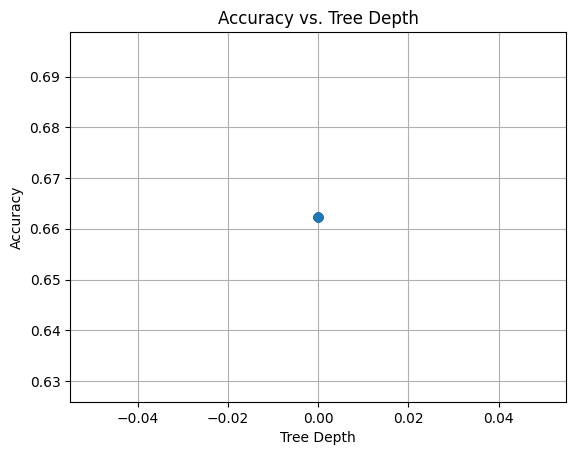

Predicted: 0


In [10]:
# Function to prune the tree using reduced error pruning
def reduced_error_pruning(node, X_val, y_val):
    if node.label is not None:
        return  # Leaf node, cannot be pruned

    # Recursively prune child nodes
    for value, child in node.children.items():
        reduced_error_pruning(child, X_val, y_val)

    # Calculate error without pruning
    predictions = [predict_tree(node, row) for _, row in X_val.iterrows()]
    original_accuracy = accuracy_score(y_val, predictions)

    # Prune the node and calculate error after pruning
    node.label = Counter(y_val).most_common(1)[0][0]
    predictions_pruned = [predict_tree(node, row) for _, row in X_val.iterrows()]
    pruned_accuracy = accuracy_score(y_val, predictions_pruned)

    # If pruning improves accuracy, keep the node pruned; otherwise, revert
    if pruned_accuracy >= original_accuracy:
        node.children = {}  # Remove child nodes

# Apply reduced error pruning to the tree
reduced_error_pruning(tree, X_test, y_test)

# Calculate and plot accuracy-depth graph
depths = []
accuracies = []

def calculate_depth(node, depth):
    if node.label is not None:
        return depth
    else:
        max_depth = depth
        for value, child in node.children.items():
            child_depth = calculate_depth(child, depth + 1)
            max_depth = max(max_depth, child_depth)
        return max_depth
    
def prune_to_depth(node, depth):   
    if depth == 0:
        # If depth is 0, make this node a leaf node
        node.children = {}
        node.is_leaf = True
        return
    if not node.children:
        # If there are no children, this is already a leaf node
        return
    for value in list(node.children.keys()):
        child = node.children[value]
        prune_to_depth(child, depth - 1)

def calculate_accuracy_depth(node, X_val, y_val):
    depth = calculate_depth(node, 0)
    predictions = [predict_tree(node, row) for _, row in X_val.iterrows()]
    accuracy = accuracy_score(y_val, predictions)
    return depth, accuracy


for i in range(1, 10):  # Vary the depth from 1 to 10 for the graph
    tree_copy = copy.deepcopy(tree)  # Create a copy of the original tree
    prune_to_depth(tree_copy, i)
    depth, accuracy = calculate_accuracy_depth(tree_copy, X_test, y_test)
    depths.append(depth)
    accuracies.append(accuracy)

plt.plot(depths, accuracies, marker='o', linestyle='-')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Tree Depth")
plt.grid(True)
plt.show()

# Print the pruned tree in hierarchical fashion
def print_pruned_tree(node, depth=0):
    if node.label is not None:
        print("  " * depth + f"Predicted: {node.label}")
    else:
        print("  " * depth + f"Attribute {node.feature}")
        for value, child in node.children.items():
            print("  " * (depth + 1) + f"Value {value}:")
            print_pruned_tree(child, depth + 2)

print_pruned_tree(tree)
